
*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  12.3.2024

--- 

# Emission Factor Variability Test

<!--Notebook description and usage information-->


In [16]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns

# import custom modules
sys.path.append('../utils')
import data_paths

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Import Emission Factor Tables

In [17]:
ef_austria = pd.read_excel(data_paths.EF_path + 'ef_eval/EFA_HOT_Vehcat_austria_main_cat_10deg.XLS')
ef_france = pd.read_excel(data_paths.EF_path + 'ef_eval/EFA_HOT_Vehcat_france_main_cat_10deg.XLS')
ef_germany = pd.read_excel(data_paths.EF_path + 'ef_eval/EFA_HOT_Vehcat_germany_main_cat_10deg.XLS')
ef_swiss = pd.read_excel(data_paths.EF_path + 'ef_eval/EFA_HOT_Vehcat_switzerland_main_cat_10deg.XLS')

ef_germany['country'] = 'Germany'
ef_austria['country'] = 'Austria'
ef_swiss['country'] = 'Switzerland'
ef_france['country'] = 'France'

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


# Calculate EF Variability
In this analysis, the emission factors of different countries and years are combine and their spread investigated. This provides insight into the relative emission factor uncertainty induced by different vehicle fleets (age and composition). 


Ambient condition: 10°C </br>
Road gradient: 0% 

In [18]:
# combine emission factor tables
year_of_interest = 2019
year_variation = 4
country_of_interest = 'Germany'

column_name = f'{country_of_interest}_{year_of_interest}'

# combine emission factors
ef_table = pd.concat([ef_germany])
ef_table[['preamble', 'road_type', 'hbefa_speed', 'traffic_situation']] = ef_table.apply(\
    lambda row: row['TrafficSit'].split('/'),result_type="expand", axis =1)

# reduce to interesting years 
ef_table = ef_table[ef_table['Year'].isin(range(year_of_interest-year_variation,
                                                year_of_interest+year_variation))]

ef_grouped_stat = ef_table.groupby(['VehCat', 'Component', 'TrafficSit']).agg({'EFA_weighted':['min', 'max']})
ef_grouped_stat = ef_grouped_stat.droplevel(level = 0, axis = 1)
_ef_coi = ef_table.set_index(['VehCat', 'Component', 'TrafficSit'])
ef_coi = _ef_coi[(_ef_coi['country']== country_of_interest) & (_ef_coi['Year']== year_of_interest)]['EFA_weighted']

ef_grouped = pd.merge(ef_coi, ef_grouped_stat, left_index=True, right_index=True)
ef_grouped = ef_grouped.rename(columns={'EFA_weighted': column_name})

ef_grouped['rel_min'] = -((ef_grouped[column_name] - ef_grouped['min'])/ ef_grouped[column_name])
ef_grouped['rel_max'] = -((ef_grouped[column_name] - ef_grouped['max'])/ ef_grouped[column_name])

ef_grouped

Germany_2019          min  \
VehCat    Component TrafficSit                                            
pass. car CO        URB/MW-Nat./120/Freeflow      0.625343     0.548627   
                    URB/MW-Nat./120/Heavy         0.379163     0.345480   
                    URB/MW-Nat./120/Satur.        0.730747     0.639397   
                    URB/MW-Nat./120/St+Go         0.455270     0.398642   
                    URB/MW-Nat./120/St+Go2        0.779131     0.618722   
...                                                    ...          ...   
HGV       CO2e      URB/Access/30/Freeflow      593.442017   571.718933   
                    URB/Access/30/Heavy         599.979126   578.970215   
                    URB/Access/30/Satur.        846.360779   814.701294   
                    URB/Access/30/St+Go        1225.227783  1178.912231   
                    URB/Access/30/St+Go2       1607.800903  1545.624756   

                                                      max   rel_min   rel_max  
VehCat    Component TrafficSit                                                 
pass. car CO        URB/MW-Nat./120/Freeflow     0.744249 -0.122677  0.190146  
                    URB/MW-Nat./120/Heavy        0.444877 -0.088835  0.173314  
                    URB/MW-Nat./120/Satur.       0.869055 -0.125009  0.189269  
                    URB/MW-Nat./120/St+Go        0.579290 -0.124383  0.272410  
                    URB/MW-Nat./120/St+Go2       1.080424 -0.205882  0.386703  
...                                                   ...       ...       ...  
HGV       CO2e      URB/Access/30/Freeflow     627.081299 -0.036605  0.056685  
                    URB/Access/30/Heavy        640.172791 -0.035016  0.066992  
                    URB/Access/30/Satur.       896.232422 -0.037407  0.058925  
                    URB/Access/30/St+Go       1302.478516 -0.037802  0.063050  
                    URB/Access/30/St+Go2      1727.251465 -0.038672  0.074294  

[900 rows x 5 columns]

In [19]:
ef_test_result = ef_grouped.reset_index().groupby(['VehCat', 'Component'])[['rel_min', 'rel_max']].median().reset_index()
ef_test_result = ef_test_result.pivot(index='Component', columns =['VehCat'])
ef_test_result.to_csv(data_paths.EF_path + 'EF_sensitivity.csv')

# plot values in table
cm = sns.diverging_palette(5, 250, s = 75, as_cmap=True)
divnorm = colors.TwoSlopeNorm(vmin=ef_test_result.values.min(), vcenter=0, vmax=ef_test_result.values.max())
ef_test_result.style.background_gradient(cmap=cm, axis=None, vmin=0, vmax=1, gmap=ef_test_result.apply(divnorm)).format("{:.1%}")

# Plot spread for all emission components of an individual vehicle class

Text(0.5, 0, 'Relative difference from reference EF [%]')

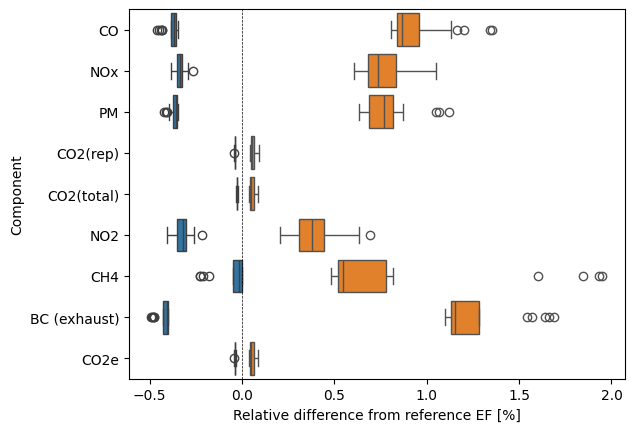

In [20]:
vehicle_class = 'HGV'
sns.boxplot(data = ef_grouped.loc[vehicle_class], x='rel_min', y='Component')
sns.boxplot(data = ef_grouped.loc[vehicle_class], x='rel_max', y='Component')

plt.axvline(0, color = 'black', linewidth = 0.5, linestyle = '--')
plt.xlabel('Relative difference from reference EF [%]')

# Investigate the emission factor for the most prominent road categories in Munich

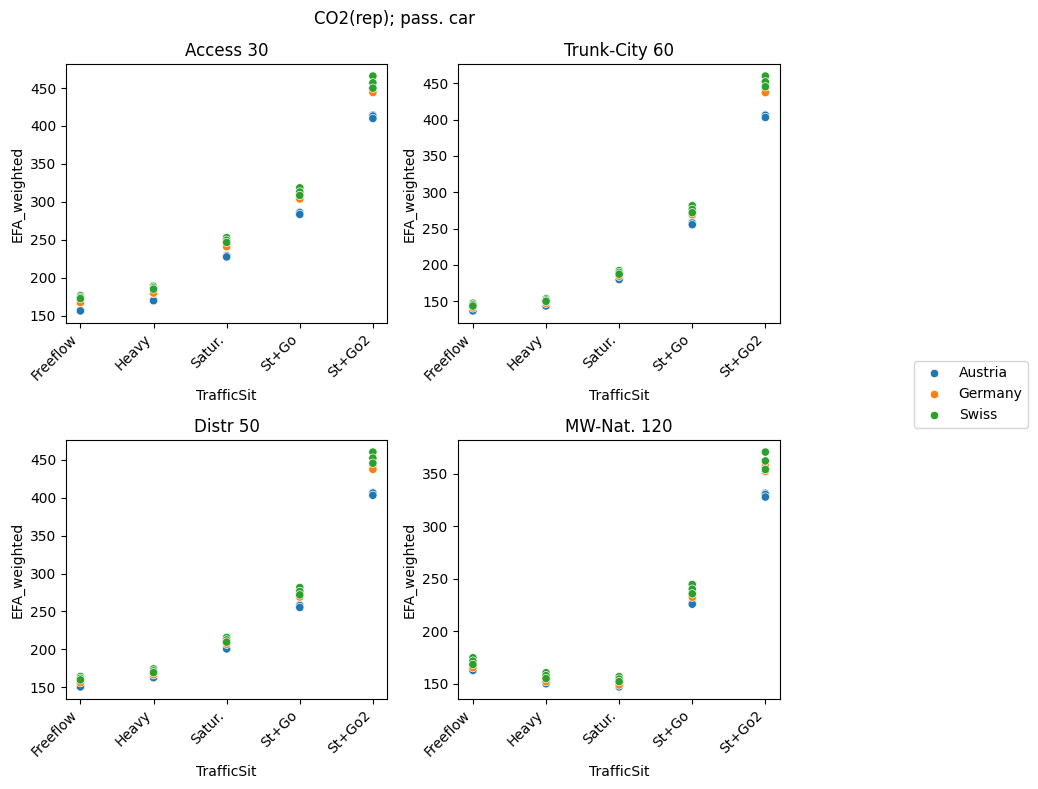

In [21]:
vehicle_category = 'pass. car'
component = 'CO2(rep)'
years = [2018, 2019, 2020]

_comb = pd.concat([ef_austria, ef_germany, ef_swiss])
comb = _comb[(_comb['VehCat'] == vehicle_category) & 
                   (_comb['Component'] == component) & 
                   (_comb['Year'].isin(years))]

# plotting
fig, ax = plt.subplots(2,2, figsize = (8,8), tight_layout = True)
loc = [0,0]

for cat in ['URB/Access/30', 'URB/Distr/50', 'URB/Trunk-City/60', 'URB/MW-Nat./120']:
    data = comb[comb['TrafficSit'].str.contains(cat)]
    
    sns.scatterplot(ax = ax[*loc], data=data, x = 'TrafficSit',
                    y = 'EFA_weighted', hue ='TrafficScenario')
    
    ax[*loc].get_legend().remove()
    labels = ax[*loc].get_xticklabels()
    labels_updated = [str(l).split('/')[3][:-2] for l in labels]
    ax[*loc].set_xticks(ax[*loc].get_xticks(), labels_updated,
                        rotation=45, ha='right')
    ax[*loc].set_title(' '.join(cat.split('/')[1:]))
   
   # increment axis
    loc[0]+=1
    if loc[0]>1:
        loc[0]=0
        loc[1]+=1

plt.subplots_adjust(hspace=0.4)
plt.xticks(rotation=45, ha='right')
plt.suptitle(component + '; ' + vehicle_category)

# prepare legend
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = ['Austria', 'Germany', 'Swiss']
by_label = dict(zip(updated_labels, handles))
fig.legend(by_label.values(),
           by_label.keys(),
           bbox_to_anchor=(1.3, 0.55))